# Part 2: Genres and communities and plotting 


In [1]:
# Load graph with genres without including isolated nodes
import json
import networkx as nx
import requests
import gzip
import io
import os

local_network = "data/rock_band_graph_isolated_genres.json.gz"
read_graph_kwargs = {"comments": "#", "delimiter": "|", "create_using": nx.DiGraph()}

if os.path.exists(local_network):
    with gzip.open(local_network, "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
    print(
        f"Loaded graph with {G_bands.number_of_nodes()} nodes and {G_bands.number_of_edges()} edges containing bands and genres.",
        f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}",
        sep="\n",
    )
else:
    print("Graph file not found.")

Loaded graph with 484 nodes and 7323 edges containing bands and genres.
Graph component count: 1


### Exercise) Write about genres and modularity.



**Modularity** measures how well a network is divided into communities.  
It compares the actual number of edges within communities to the expected number if edges were randomly distributed while preserving node degrees.  
The modularity score ranges from **–0.5 to 1.0**, with the following interpretations:

- **High modularity (≈ 1):** Well-defined communities with dense internal connections and few connections between them.  
- **Low modularity (≈ 0):** Poorly defined communities, with edges distributed almost randomly.  
- **Negative modularity:** Worse than random, with more edges connecting different communities than nodes within them.

The network has to be divided into communities/partitions to be able to measure its modularity. In our network of artists, each node represents a musician or band containing the **genres** associated with them, and edges represent Wikipedia links between them. We will use these genres as grouping features to form communities within the network and then, using the modularity metric, measure how accurately these communities are formed.

##### **Network's modularity calculation**

To calculate the network's modularity we will use the function below, based on the equation $(9.12)$ described in the *Network Science* book:
$$M = \sum_{c=1}^{n_c} \left[ \frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2 \right]$$

where
- $L_c =$ number of edges within communities/partition $c$  
- $L =$ total number of edges  
- $k_c =$ sum of degrees of nodes in communities/partition $c$

In [16]:
# ============================================================================
# MODULARITY CALCULATION FUNCTION (Equation 9.12)
# ============================================================================
def calculate_modularity(G, partition):
    """
    Calculate modularity using equation 9.12 from Network Science book.

    M = Σ_c [L_c/m - (k_c/2*L)²]

    where:
    - L_c = number of edges within community c
    - L = total number of edges/links
    - k_c = sum of degrees of nodes in community c

    Parameters:
    - G: NetworkX graph
    - partition: dict mapping node -> community
    Returns:
    - modularity value (float)
    """
    if len(G.edges()) == 0:
        return 0.0

    L = G.number_of_edges()  # Total number of edges

    # Group nodes by community
    communities = {}
    for node, comm in partition.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)

    modularity = 0.0
    # Calculate modularity for each community
    for comm, nodes_in_comm in communities.items():
        # l_c: number of edges within the community
        L_c = 0
        for u in nodes_in_comm:
            for v in nodes_in_comm:
                if G.has_edge(u, v):
                    L_c += 1
        L_c = L_c / 2  # Each edge counted twice in undirected graph

        # d_c: sum of degrees of all nodes in community
        k_c = sum(G.degree(node) for node in nodes_in_comm)

        # Add contribution to modularity: l_c/m - (d_c/2m)²
        modularity += (L_c / L) - (k_c / (2 * L)) ** 2

    return modularity

In [2]:
from collections import Counter


total_genres = 0
nodes_with_genres = 0
distinct_genres_set = set()
for i, (node, genres) in enumerate(G_bands.nodes(data=True)):
    if "genres" in genres:
        nodes_with_genres += 1
        total_genres += len(genres["genres"])
        distinct_genres_set.update(genres["genres"])
avg_genres = total_genres / nodes_with_genres if nodes_with_genres > 0 else 0
distinct_genres = len(distinct_genres_set)
# Report statistics
print("\nGenre Extraction Statistics:")
print(f"- Number of nodes with genres: {nodes_with_genres}")
print(f"- Average number of genres per node: {avg_genres:.2f}")
print(f"- Total distinct genres: {distinct_genres}")


Genre Extraction Statistics:
- Number of nodes with genres: 482
- Average number of genres per node: 3.58
- Total distinct genres: 191


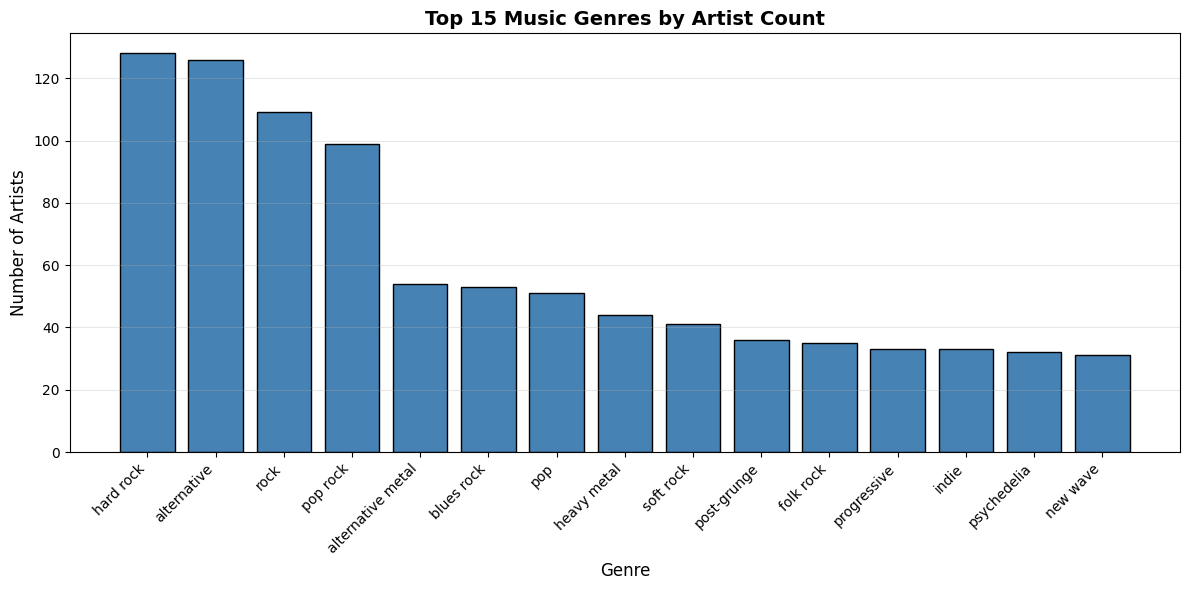

In [3]:
import matplotlib.pyplot as plt
# Count genre occurrences
genre_counter = Counter()
for node, genres in G_bands.nodes(data=True):
    if "genres" in genres:
        genre_counter.update(genres["genres"])
# Get top 15 genres
top_15_genres = genre_counter.most_common(15)
# Create histogram for top 15 genres
plt.figure(figsize=(12, 6))
genres_names = [g[0] for g in top_15_genres]
genres_values = [g[1] for g in top_15_genres]

plt.bar(range(len(genres_names)), genres_values, color="steelblue", edgecolor="black")
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number of Artists", fontsize=12)
plt.title("Top 15 Music Genres by Artist Count", fontsize=14, fontweight="bold")
plt.xticks(range(len(genres_names)), genres_names, rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y", alpha=0.3)
plt.show()

The histogram above shows the artist distribution across the top 15 genres.  
The distribution is noticeably **skewed**, with the categories being mainly types of **rock music** including *hard rock*, *alternative*, and *pop rock* alongside *alternative* music in general.  

### Exercise) Detect the communities, discuss the value of modularity in comparison to the genres.



In [17]:
# filter the graph to only include nodes with genres
G_undirected = G_bands.to_undirected()


nodes_with_genres_list = [
    node
    for node in G_undirected.nodes()
    if "genres" in G_undirected.nodes[node] and G_undirected.nodes[node]["genres"]
]

G_genres = G_undirected.subgraph(nodes_with_genres_list).copy()

# create genres dictionary
genres_dict = {}
for node, data in G_genres.nodes(data=True):
    genres_dict[node] = data["genres"]
# get top 6 genres
genre_counts = Counter()
for genres in genres_dict.values():
    genre_counts.update(genres)




To assess whether musical genres naturally form well-defined communities in the artist network, we explored several partitioning strategies:

- Selecting the first genre which is usually `rock`.
- Selecting the first genre *that's not `rock`* as the genre-assignment for all nodes that have more than one genre
- Using a random genre from the list genre as the node-label for those nodes with more than one genre


In [22]:
# PARTITION STRATEGY 1 : FIRST GENRE
import random
from collections import Counter

print("PARTITION STRATEGY 1 : FIRST GENRE")
print("=" * 40)

partition_first = {}
for node in G_genres.nodes():
    genres = G_genres.nodes[node]["genres"]
    partition_first[node] = genres[0]  # Use first genre

# Count communities
communities_first = set(partition_first.values())
print(f"Number of genre-based communities: {len(communities_first)}")

# Calculate modularity
modularity_first = calculate_modularity(G_genres, partition_first)
print(f"\nModularity (first genre): {modularity_first:.4f}")

# Verify with NetworkX
modularity_nx_first = nx.community.modularity(
    G_genres,
    [
        set([n for n in G_genres.nodes() if partition_first[n] == genre])
        for genre in communities_first
    ],
)
print(f"Modularity (NetworkX verification): {modularity_nx_first:.4f}")

PARTITION STRATEGY 1 : FIRST GENRE
Number of genre-based communities: 74

Modularity (first genre): 0.1033
Modularity (NetworkX verification): 0.1033


In [21]:
# PARTITION STRATEGY 2: FIRST NON-ROCK GENRE
print("PARTITION STRATEGY 2: FIRST NON-ROCK GENRE")
print("=" * 80)

partition_non_rock = {}
for node in G_genres.nodes():
    genres = G_genres.nodes[node]["genres"]
    # Find first genre that's not 'rock'
    non_rock_genre = None
    for genre in genres:
        if genre != "rock":
            non_rock_genre = genre
            break
    # If all genres are 'rock' or only one genre, use first genre
    partition_non_rock[node] = non_rock_genre if non_rock_genre else genres[0]

# Count communities
communities_non_rock = set(partition_non_rock.values())
print(f"Number of genre-based communities: {len(communities_non_rock)}")

# Calculate modularity
modularity_non_rock = calculate_modularity(G_genres, partition_non_rock)
print(f"\nModularity (first non-rock genre): {modularity_non_rock:.4f}")

# Verify with NetworkX
modularity_nx_non_rock = nx.community.modularity(
    G_genres,
    [
        set([n for n in G_genres.nodes() if partition_non_rock[n] == genre])
        for genre in communities_non_rock
    ],
)
print(f"Modularity (NetworkX verification): {modularity_nx_non_rock:.4f}")

PARTITION STRATEGY 2: FIRST NON-ROCK GENRE
Number of genre-based communities: 81

Modularity (first non-rock genre): 0.0833
Modularity (NetworkX verification): 0.0833


In [20]:
# PARTITION STRATEGY 3: RANDOM GENRE
print("PARITION STRATEGY 3: RANDOM GENRE")
print("=" * 40)

# Set seed for reproducibility
random.seed(42)

partition_random = {}
for node in G_genres.nodes():
    genres = G_genres.nodes[node]["genres"]
    partition_random[node] = random.choice(genres)

# Count communities
communities_random = set(partition_random.values())
print(f"Number of genre-based communities: {len(communities_random)}")


# Calculate modularity
modularity_random = calculate_modularity(G_genres, partition_random)
print(f"\nModularity (random genre): {modularity_random:.4f}")

# Verify with NetworkX
modularity_nx_random = nx.community.modularity(
    G_genres,
    [
        set([n for n in G_genres.nodes() if partition_random[n] == genre])
        for genre in communities_random
    ],
)
print(f"Modularity (NetworkX verification): {modularity_nx_random:.4f}")

PARITION STRATEGY 3: RANDOM GENRE
Number of genre-based communities: 109

Modularity (random genre): 0.0416
Modularity (NetworkX verification): 0.0416


In [24]:
# LOUVAIN COMMUNITY DETECTION WITH DEFAULT RESOLUTION
# ===========================
import networkx.algorithms.community as nx_comm

print("STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM")
print("=" * 50)

# Apply Louvain algorithm to find communities
louvain_communities = nx_comm.louvain_communities(G_genres,  seed=42)

print(f"Number of communities found: {len(louvain_communities)}")

# Calculate modularity of the partition
louvain_modularity = nx_comm.modularity(G_genres, louvain_communities)
print(f"Modularity: {louvain_modularity:.4f}")

# Create partition dictionary (node -> community_id)
louvain_partition = {}
for comm_id, nodes in enumerate(louvain_communities):
    for node in nodes:
        louvain_partition[node] = comm_id

# Show community size distribution
community_sizes = [len(comm) for comm in louvain_communities]
community_sizes.sort(reverse=True)

print("\nCommunity sizes (top 20):")
for i, size in enumerate(community_sizes[:20], 1):
    print(f"  Community {i:2d}: {size:4d} nodes")

STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM
Number of communities found: 5
Modularity: 0.3387

Community sizes (top 20):
  Community  1:  160 nodes
  Community  2:  147 nodes
  Community  3:  119 nodes
  Community  4:   53 nodes
  Community  5:    3 nodes


In [25]:
# GENRE DISTRIBUTION WITHIN EACH OF THE LOUVAIN COMMUNITIES

import pandas as pd
from collections import Counter
from IPython.display import display

sorted_louvain_communities = sorted(
    louvain_communities, key=lambda x: len(x), reverse=True
)

data = {}
max_genres = 10

for idx, nodes_in_comm in enumerate(sorted_louvain_communities, 1):
    col_name = f"Community {idx} ({len(nodes_in_comm)} nodes)"
    
    community_genres = []
    for node in nodes_in_comm:
        if "genres" in G_genres.nodes[node]:
            community_genres.extend(G_genres.nodes[node]["genres"])
    
    genre_counter = Counter(community_genres)
    most_common_genres = genre_counter.most_common(max_genres)
    
    genre_list = [f"{genre} ({count})" for genre, count in most_common_genres]
    # Add dashes if community has less than 10 genres
    while len(genre_list) < max_genres:
        genre_list.append("---")
    
    data[col_name] = genre_list

df_communities = pd.DataFrame(data, index=range(1, max_genres + 1))
df_communities.index.name = "Rank"

display(df_communities)

,Community 1 (160 nodes),Community 2 (147 nodes),Community 3 (119 nodes),Community 4 (53 nodes),Community 5 (3 nodes)
Rank,,,,,
1,rock (85),alternative (84),hard rock (68),alternative (31),funk (2)
2,pop (41),pop rock (42),heavy metal (36),hard rock (31),psychedelic funk (2)
3,pop rock (37),indie (32),blues rock (21),post-grunge (30),funk rock (2)
4,soft rock (33),new wave (21),alternative metal (19),alternative metal (29),acid rock (2)
5,blues rock (28),pop-punk (20),glam metal (16),nu metal (9),soul (2)
6,folk rock (26),punk (19),arena rock (15),pop rock (5),r&b (1)
7,blues (22),post-punk (17),pop rock (15),heavy metal (5),psychedelia (1)
8,psychedelia (21),art rock (16),progressive (12),grunge (4),---
9,hard rock (19),power pop (13),rock (11),rap metal (3),---


## Community Detection and Comparison with Genres

| Strategy | Number of Communities | Modularity |
|-----------|------------------|-------------|
| Using the first genre (usually Rock) | 74 | 0.1033 |
| Using the first non-Rock genre | 81 | 0.0833 |
| Using a random genre | 109 | 0.0416 |

These results indicate that **genres are weak indicators of community structure**. 
We find a large number of communities and low modularity values across all strategies, meaning that artists connected through Wikipedia links do not cluster strongly based on shared genres.  
Instead, links between artists are likely influenced by a combination of other factors such as collaborations, stylistic influences, historical periods, geographic origins, or record labels.

In other words, **genres are not “good communities.”**  
Most artists end up belonging to one large, weakly defined group rather than clear, genre-based clusters.

---

## Louvain Algorithm Results

The **Louvain community detection algorithm** operates in two main phases.  
First, it identifies "small" communities by locally optimizing modularity.  
Then, it aggregates nodes belonging to the same community to form a new network whose nodes represent these communities.  
These steps are repeated iteratively until modularity reaches its maximum.  

In essence, the algorithm seeks the **partition that maximizes modularity**, meaning it produces a relatively small number of well-connected communities with dense internal edges and few external ones.

We identify **five major communities** in the network and obtain a **modularity of 0.3387**, which is relatively high compared to the values achieved when using genres as the community-defining factor.

**Identified communities:**
   
- **Community 1 (160 nodes)**: Rock & Pop Classics
  - Dominated by: rock, pop, pop rock, soft rock, blues rock, folk rock
  - Top nodes (highest degrees): Bob Dylan (65), Elvis Presley (51), Eric Clapton (50), The Beatles (49)
  - Character: Mainstream classic rock and pop from 60s-80s

- **Community 2 (147 nodes)**: Alternative & Indie
  - Dominated by: alternative, pop rock, indie, new wave, pop-punk, punk
  - Top nodes (highest degrees): U2 (45), Green Day (42), David Bowie (41), Nirvana (39)
  - Character: Alternative and indie scene spanning 80s-2000s

- **Community 3 (119 nodes)**: Hard Rock & Metal
  - Dominated by: hard rock, heavy metal, blues rock, alternative metal, arena rock
  - Top nodes (highest degrees): Metallica (60), Black Sabbath (56), Led Zeppelin (52), Deep Purple (48)
  - Character: Guitar-driven hard rock and metal

- **Community 4 (53 nodes)**: Post-Grunge & Alternative Metal
  - Dominated by: alternative, hard rock, post-grunge, alternative metal, nu metal
  - Top nodes (highest degrees): Breaking Benjamin (26), Shinedown (24), Three Days Grace (22)
  - Character: 90s-2000s post-grunge and alternative metal

- **Community 5 (3 nodes)**: Funk & Psychedelic
  - Dominated by: funk, psychedelic funk, funk rock, acid rock, soul
  - Top nodes (highest degrees): Parliament-Funkadelic (2), Funkadelic (2), Parliament (2)
  - Character: Niche funk and psychedelic styles


This result reinforces the idea that, when the **network structure itself** dictates the grouping, rather than imposing genre labels, the artist network naturally organizes into a few large communities.  
This suggests that connections are driven by broader, cross-genre relationships such as historical periods and stylistic similarities rather than by genres.


### Exercise) Calculate the matrix $D$ and discuss your findings.


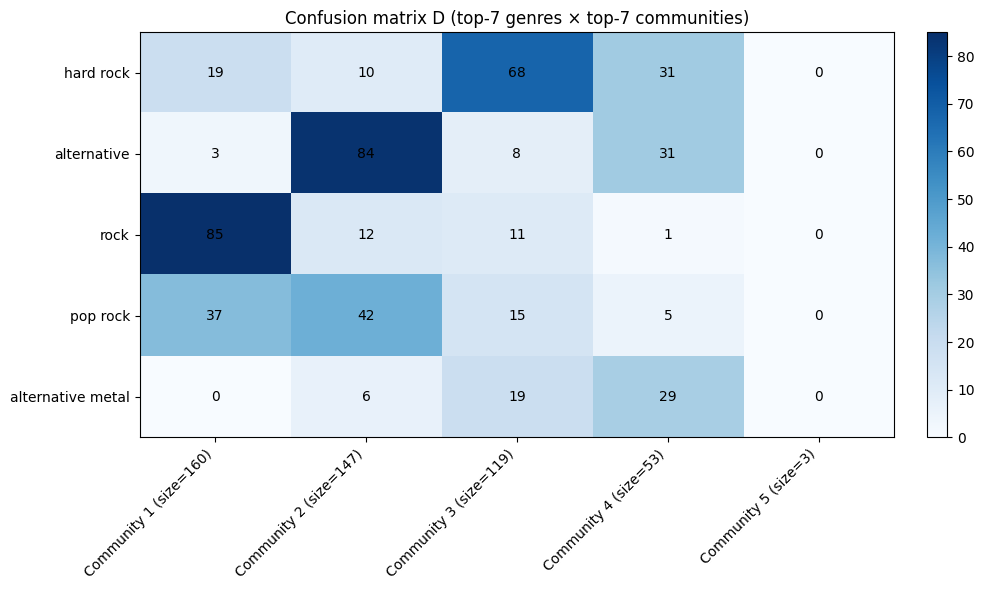

In [26]:
# Build confusion matrix D (top genres x louvain communities)
import numpy as np

# Initialize D 2D array matrix
louvain_community_count = len(sorted_louvain_communities)
D = np.zeros((louvain_community_count, louvain_community_count), dtype=int)

most_common_genres = [g for g, _ in genre_counts.most_common(louvain_community_count)]
genre_to_row = {genre: idx for idx, genre in enumerate(most_common_genres)}

node_to_community = {}
for comm_id, comm in enumerate(sorted_louvain_communities):
    for node in comm:
        node_to_community[node] = comm_id

# Fill D: for each node, if node belongs to one of top communities AND has at least one of the top genres,
for node in node_to_community.keys():
    # increment counts for each matching genre (use all genres associated with node)
    matched = False
    for g in genres_dict.get(node, []):
        if g in genre_to_row:
            D[genre_to_row[g], node_to_community[node]] += 1
            matched = True

comm_labels = [f"Community {cid +1} (size={len(comm)})" for cid, comm in enumerate(sorted_louvain_communities)]
df_D = pd.DataFrame(D, index=most_common_genres, columns=comm_labels)

# Plot confusion matrix D
plt.figure(figsize=(10, 6))
im = plt.imshow(df_D.values, cmap="Blues", aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(df_D.columns)), df_D.columns, rotation=45, ha="right")
plt.yticks(range(len(df_D.index)), df_D.index)
plt.title("Confusion matrix D (top-7 genres × top-7 communities)")

for i in range(df_D.shape[0]):
    for j in range(df_D.shape[1]):
        plt.text(j, i, df_D.iat[i, j], ha="center", va="center", color="black")

plt.tight_layout()
plt.show()

The confusion matrix displays the five communities identified using the **Louvain algorithm** in relation with the five listed genres are the most common accross all artists.  

## Genre Distribution Across Communities

Since each band can belong to multiple genres, the sum of the genre counts often exceeds the total number of nodes in a community.

We observe that a single genre typically dominates each community. However, because communities are **not formed based on musical genres**, the distribution of genres is spread across multiple categories within each community.

For example, the node with the highest value appears in **Community 1**, which might initially suggest it represents bands mainly associated with **rock**.  
A closer look reveals a substantial presence of **pop rock** as well, illustrating that even this community is **not purely genre-driven**.

**Community 3**, in contrast, appears to be the most **genre-driven** among the five communities.  
The distribution of nodes across its main genres is more pronounced: **68 nodes** are associated with **hard rock**, while the next most common genre shown in the matrix has only **19 nodes**.  
However, the true second-largest group within this community is **heavy metal**, with **36 occurrences**, which does not appear in the matrix because it is not among the five most common genres displayed.  
This highlights that, while some communities show stronger genre patterns, genres alone are still **not good indicators of community structure**.


Overall, the low modularity values across all genre-based strategies demonstrate that **Wikipedia artist links are not primarily formed by shared musical genres**.  
While genre remains a useful descriptive feature, it does not align well with the network’s actual community structure.  
Instead, the data reveals a more complex network of relationships, where **cultural, temporal, and social factors** play a stronger role than genre classification alone.


### Exercise) Plot the communities and comment on your results.

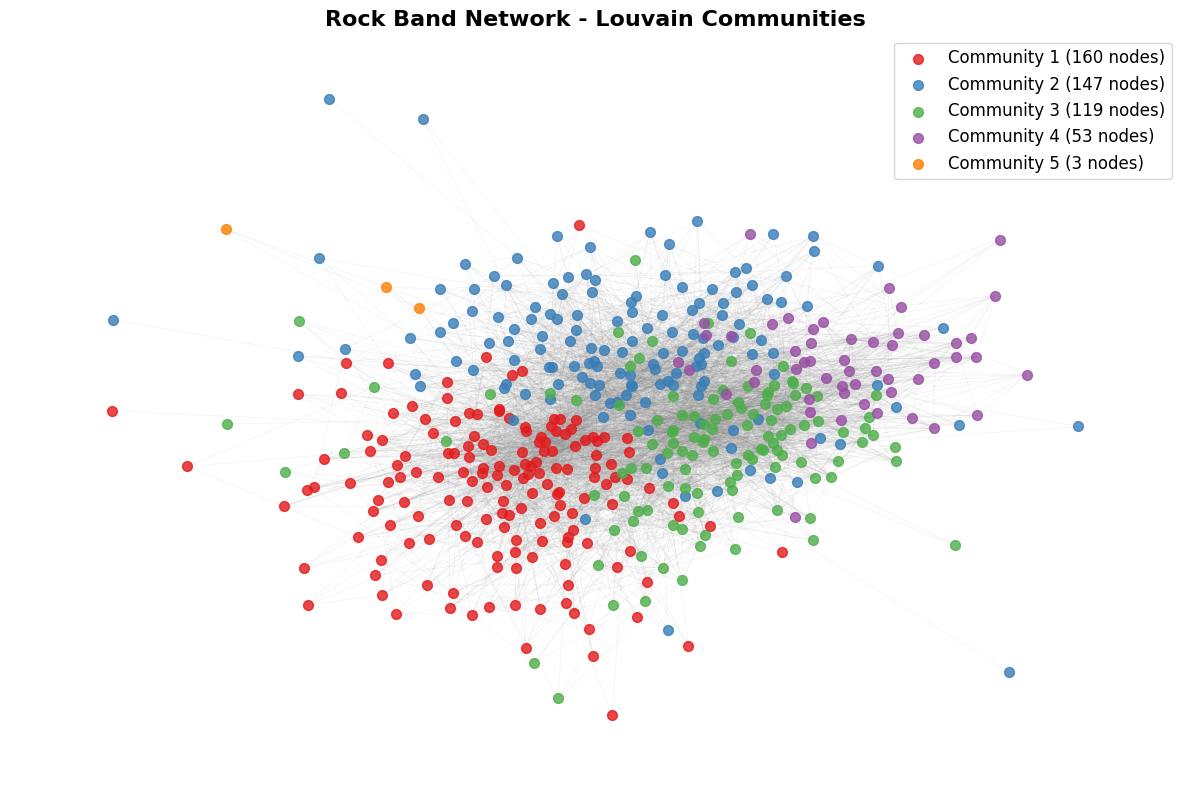

In [30]:
# VISUALIZE LOUVAIN COMMUNITIES

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_genres, seed=42)
colors = [
    "#e41a1c",
    "#377eb8",
    "#4daf4a",
    "#984ea3",
    "#ff7f00",
    "#ffff33",
]

# Draw each community
for idx, nodes_in_comm in enumerate(sorted_louvain_communities):
    node_list = list(nodes_in_comm)
    nx.draw_networkx_nodes(
        G_genres,
        pos,
        nodelist=node_list,
        node_color=colors[idx] if idx < len(colors) else "#cccccc",
        node_size=50,
        alpha=0.8,
        label=f"Community {idx + 1} ({len(node_list)} nodes)",
    )

# Draw edges with low alpha
nx.draw_networkx_edges(G_genres, pos, alpha=0.1, width=0.5, edge_color="gray")

plt.title(
    label="Rock Band Network - Louvain Communities",
    fontsize=16,
    fontweight="bold",
)
plt.legend(loc="upper right", fontsize=12)
plt.axis("off")
plt.tight_layout()
plt.show()

The plot shows the grouping of the 5 communities found using the **Louvain algorithm** in different colors.

- Community Structure is Visible

  - The nodes are grouped into **five communities**, each represented by a distinct color.  
  - **Communities 1 (red), 2 (blue), and 3 (green)** form the **densest clusters**, indicating many intra-community connections.  
  - **Community 4 (purple)** is moderately sized and somewhat connected to the green and blue communities.  
  - **Community 5 (orange)** is tiny and mostly isolated, consistent with its small node count (**3 nodes**).



- Overlap and Interconnections

  - While communities are defined by the Louvain algorithm, there are still **edges connecting nodes across communities**.  
  - This reflects the **real-world nature of music networks**: artists often have **cross-genre influences or collaborations**.



- Size Differences are Apparent

  - **Larger communities** (red, blue, green) dominate the network visually, highlighting that the majority of artists fall into a few large clusters.  
  - The **smaller communities** (purple, orange) are peripheral, reflecting **niche or specialized groups**.



- Density Patterns

  - **Community 3 (green)** and **Community 1 (red)** appear **tightly clustered**, suggesting strong internal connectivity.  
  - Some nodes at the edges are less connected, possibly representing **artists with fewer Wikipedia links** or **cross-community connections**.



- Network Insights

  - The network structure shows that **connections between artists are not purely genre-based**.  
  - **Central communities** likely correspond to **mainstream or highly connected artists**,  
    while **peripheral communities** correspond to **niche genres** (e.g., funk/psychedelic for Community 5).


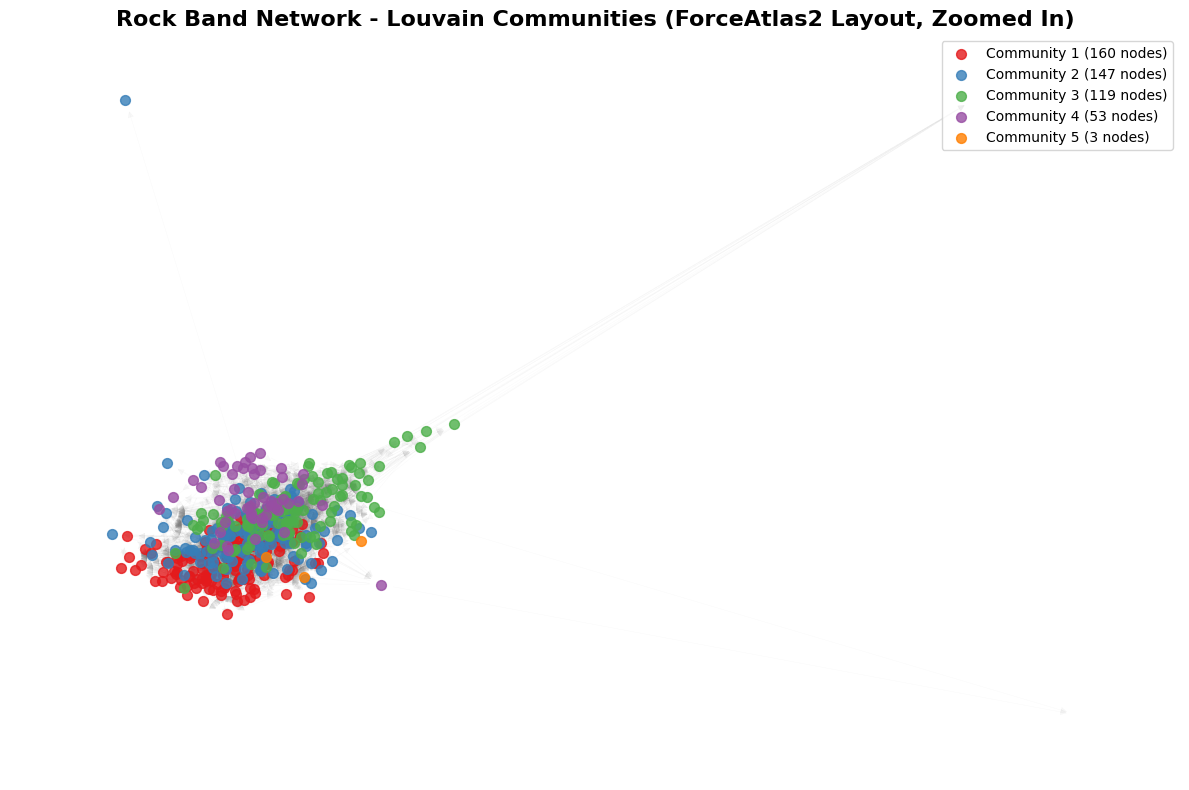

In [ ]:
# Tried to plot using ForceAtlas2 layout with zoom but did not add any value
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Assuming G_bands and sorted_louvain_communities are already defined

# Generate ForceAtlas2 layout
pos = nx.forceatlas2_layout(G_bands, seed=42)

# Apply zoom (slightly zoom in)
zoom_factor = 1.2
pos_array = np.array(list(pos.values()))
center = pos_array.mean(axis=0)
for k in pos:
    pos[k] = center + (pos[k] - center) / zoom_factor  # zoom in effect

# Define exactly 5 colors for 5 communities
colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]

plt.figure(figsize=(12, 8))

# Draw each community
for idx, nodes_in_comm in enumerate(sorted_louvain_communities[:5]):  # only 5
    nx.draw_networkx_nodes(
        G_bands,
        pos,
        nodelist=list(nodes_in_comm),
        node_color=colors[idx],
        node_size=50,
        alpha=0.8,
        label=f"Community {idx + 1} ({len(nodes_in_comm)} nodes)"
    )

# Draw light edges for structure
nx.draw_networkx_edges(G_bands, pos, alpha=0.05, width=0.3, edge_color="gray")

plt.title("Rock Band Network - Louvain Communities (ForceAtlas2 Layout, Zoomed In)",
          fontsize=16, fontweight="bold")
plt.legend(loc="upper right", fontsize=10)
plt.axis("off")
plt.tight_layout()
plt.show()
